In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from latent_geometry.model.mnist_vae import (
    load_decoder,
    load_encoder,
)

from latent_geometry.mapping import TorchModelMapping
from latent_geometry.manifold import LatentManifold
from latent_geometry.metric import EuclideanMetric
from latent_geometry.data import load_mnist_dataset
from latent_geometry.utils import project
from path_summary import main

In [3]:
# raise Exception("double check that we wont use already taken gpu ($ nvidia-smi)")
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [4]:
dataset = load_mnist_dataset('train')
imgs = torch.concatenate([img for img, label in dataset]).cuda()
imgs.shape

torch.Size([60000, 32, 32])

In [5]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cuda")
model_name, latent_dim = "latent_8_dim_beta_10", 8

ENCODER = load_encoder(DEVICE, f"{model_name}_encoder.pt", latent_dim=latent_dim)
DECODER = load_decoder(DEVICE, f"{model_name}_decoder.pt", latent_dim=latent_dim)

# z = ENCODER.sample(dataset[0][0].to(DEVICE)[None, :])
# reconstruction = DECODER.decode(z)
# reconstruction.shape

In [6]:
SOLVER_TOL = 1.0
ambient_metric = EuclideanMetric()
latent_mapping = TorchModelMapping(
    DECODER, (latent_dim,), (1, 32, 32), batch_size=1_000, call_fn=DECODER.decode
)
manifold_mnist = LatentManifold(
    latent_mapping, ambient_metric, solver_tol=SOLVER_TOL, bvp_n_mesh_nodes=1_000
)

In [7]:
with torch.no_grad():
    zs = ENCODER.encode(imgs[:, None, ...]).cpu().numpy()
zs.shape

(60000, 8)

In [8]:
from typing import Union

def show_digits(zss: list[Union[tuple[np.ndarray, ...], np.ndarray]], names: list[str] = None):
    fig, axs = plt.subplots(1, len(zss), figsize=(16, 4))
    for i, zs in enumerate(zss):
        xs = []
        if not isinstance(zs, tuple):
            zs = (zs, )
        for z in zs:
            x = project(latent_mapping)(z).reshape(32, 32)
            xs.append(x)
        img = np.concatenate(xs, axis=0)
        ax = axs[i] if len(zss) > 1 else axs
        ax.imshow(img, vmin=0, vmax=1)
        if names:
            ax.set_title(
                names[i],
                fontsize=8,
            )
        ax.set_axis_off()

In [9]:
diffs = np.eye(8)
easy_zss = zs[[0], :] + diffs * 1.0
easy_zss.shape

(8, 8)

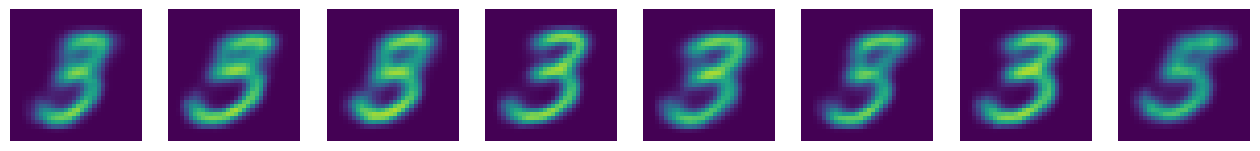

In [10]:
show_digits(easy_zss)


In [11]:
manifold_mnist.geodesic(easy_zss[0], easy_zss[3])

In [12]:
zss = [(t,) for t in zs[:10]]
# zss

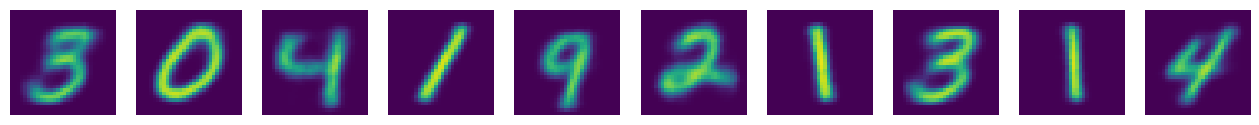

In [13]:
show_digits(zss)

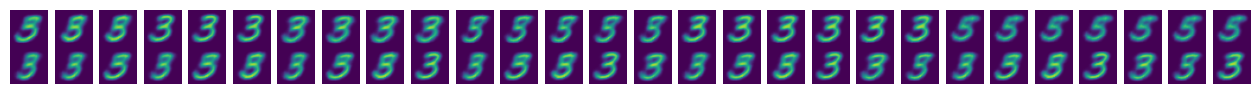

In [14]:
def pair_up(zss):
    pairs = []
    for i in range(len(zss)):
        for j in range(len(zss)):
            if j >= i:
                continue
            x, y = zss[i], zss[j]
            if isinstance(x, tuple):
                pairs.append((x[0], y[0]))
            else:
                pairs.append((x, y))
    return pairs

EASY_PAIRS = pair_up(easy_zss)
show_digits(EASY_PAIRS)

In [15]:
def sampler_gen_fn(pairs):
    for p in pairs:
        yield p


# sampler_gen = sampler_gen_fn()

# # uglyyy
# def sampler():
#     return next(sampler_gen)

In [16]:
pairs = EASY_PAIRS
sampler_gen = sampler_gen_fn(pairs)


def sampler():
    return next(sampler_gen)


main(
    model_name,
    latent_dim,
    len(pairs),
    "dim_8_first_10",
    sampler,
    solver_tols=(0.5, 1.0, 2.0),
)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:27<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/quczer/repos/latent-geometry/figures/mnist/images/8dim/paths/dim_8_first_10'